In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout



In [2]:
def carregar_dados(ticker, start='2021-01-01', end='2025-04-01'):
    df = yf.download(ticker, start=start, end=end)
    df = df[['Close']].dropna()
    return df

def preparar_dados(df, look_back=60):
    df = df[['Close']].dropna()
    
    if len(df) <= look_back:
        raise ValueError(f"Dados insuficientes: apenas {len(df)} linhas, é necessário mais que {look_back}.")

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)

    X, y = [], []
    for i in range(look_back, len(scaled)):
        X.append(scaled[i-look_back:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)
    return X, y, scaler

def criar_modelo(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [3]:
def treinar_e_avaliar(ticker, nome_ticker):
    print(f"\n📊 Treinando modelo para: {nome_ticker} ({ticker})")
    df = carregar_dados(ticker)
    X, y, scaler = preparar_dados(df)

    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    model = criar_modelo((X_train.shape[1], 1))
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    print(f"MSE: {mse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

    plt.figure(figsize=(10, 4))
    plt.plot(y_test_rescaled, label='Real')
    plt.plot(y_pred_rescaled, label='Previsto')
    plt.title(f'{nome_ticker} - Preço de Fechamento')
    plt.xlabel('Dias')
    plt.ylabel('Preço')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model



📊 Treinando modelo para: Apple (AAPL)
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
MSE: 43.1040 | MAE: 5.3873 | R²: 0.6600


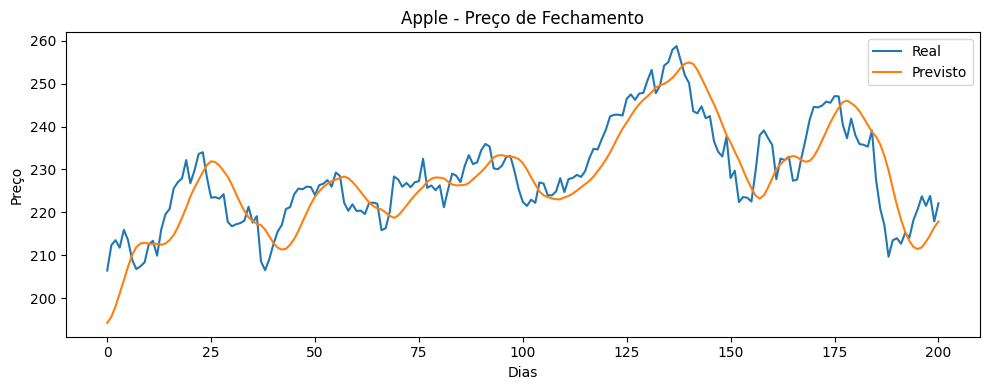


📊 Treinando modelo para: IBOVESPA (^BVSP)


[*********************100%***********************]  1 of 1 completed
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
MSE: 3434754.9424 | MAE: 1410.5434 | R²: 0.8374


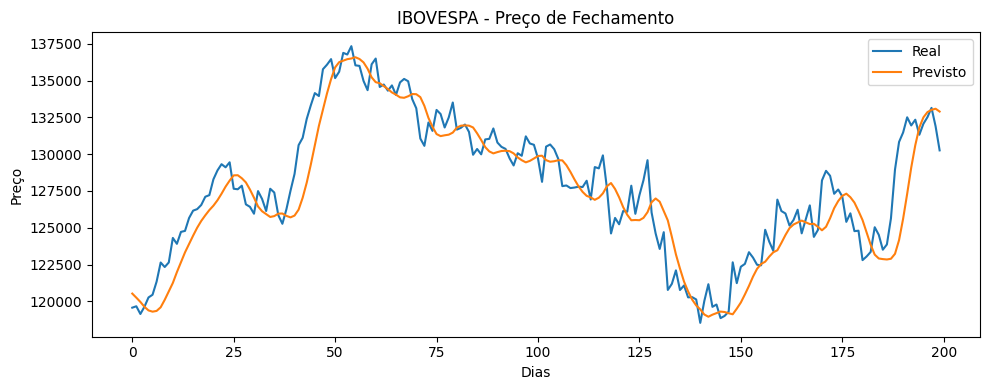


📊 Treinando modelo para: Itaú Unibanco (ITUB4.SA)


[*********************100%***********************]  1 of 1 completed
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
MSE: 0.5055 | MAE: 0.5448 | R²: 0.8112


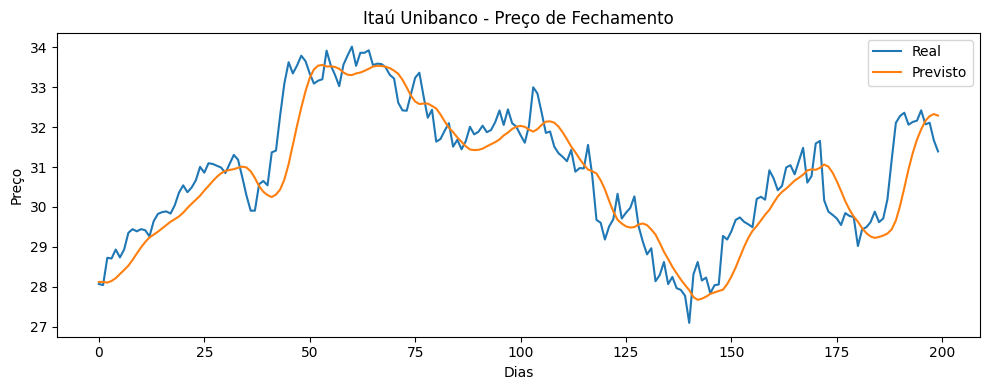


📊 Treinando modelo para: S&P 500 (^GSPC)


[*********************100%***********************]  1 of 1 completed
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
MSE: 41572.6907 | MAE: 177.2354 | R²: 0.2057


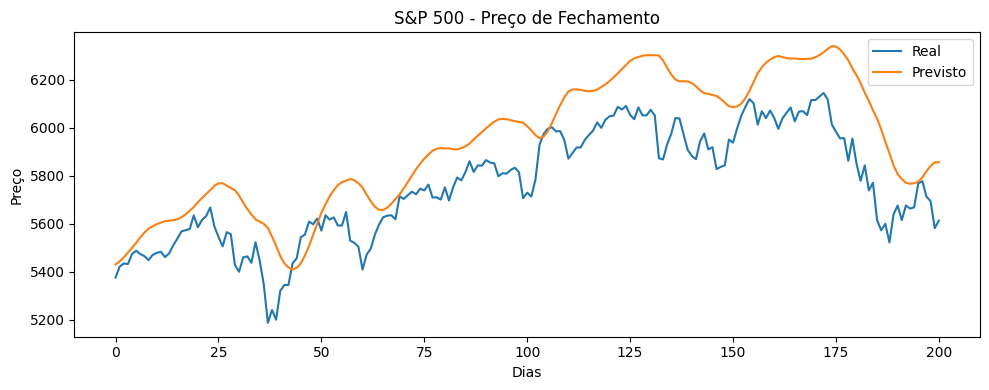

In [4]:
ativos = {
    'AAPL': 'Apple',
    '^BVSP': 'IBOVESPA',
    'ITUB4.SA': 'Itaú Unibanco',
    '^GSPC': 'S&P 500'
}

for ticker, nome in ativos.items():
    treinar_e_avaliar(ticker, nome)


[*********************100%***********************]  1 of 1 completed


 Treino modelo : Apple (AAPL)



C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
MSE: 90.3720 | MAE: 7.9758 | MAPE: 3.47% | R²: 0.2873


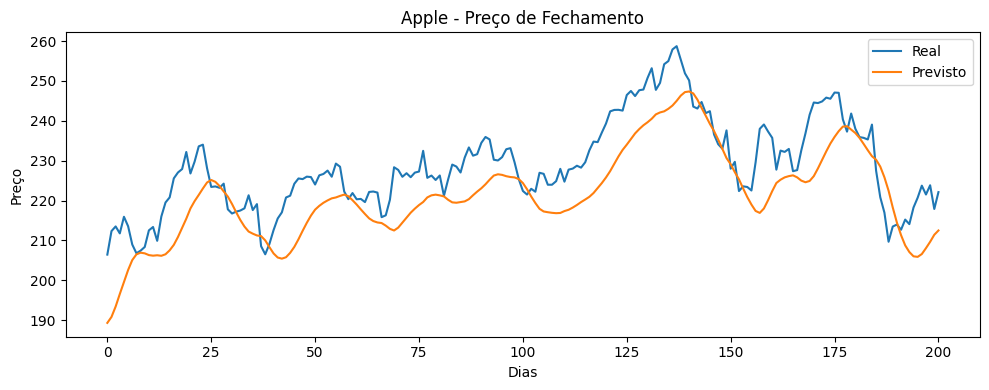

[*********************100%***********************]  1 of 1 completed


 Treino modelo : IBOVESPA (^BVSP)



C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
MSE: 3164383.9245 | MAE: 1363.4883 | MAPE: 1.07% | R²: 0.8502


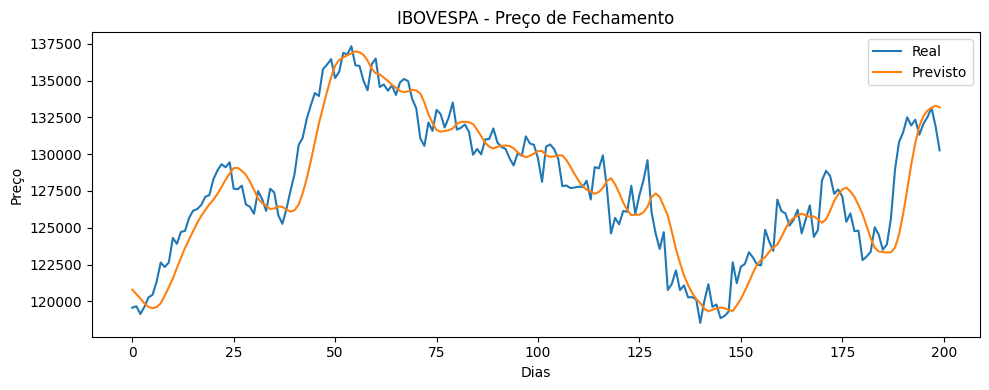


 Treino modelo : Itaú Unibanco (ITUB4.SA)


[*********************100%***********************]  1 of 1 completed
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
MSE: 0.5947 | MAE: 0.6059 | MAPE: 1.95% | R²: 0.7779


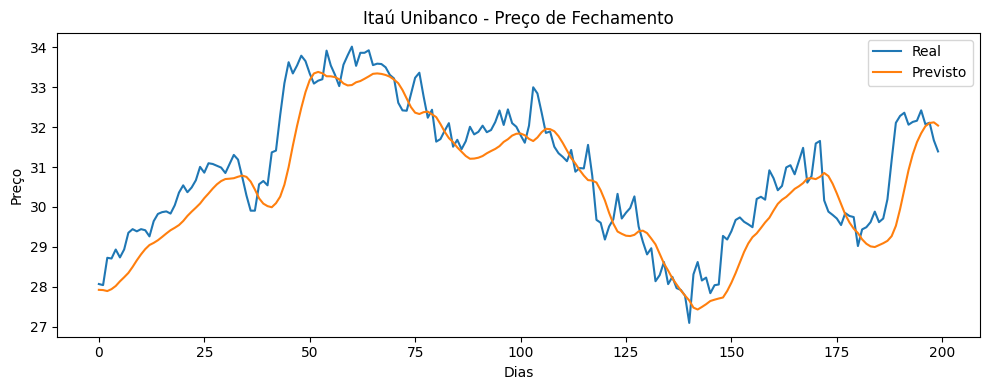

[*********************100%***********************]  1 of 1 completed


 Treino modelo : S&P 500 (^GSPC)



C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
MSE: 12199.6730 | MAE: 86.0949 | MAPE: 1.50% | R²: 0.7669


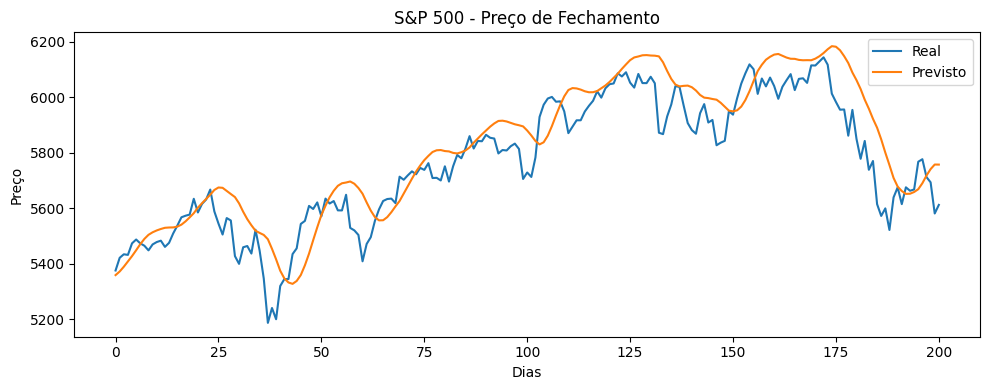

,Ativo,MSE,MAE,MAPE (%),R²
1,IBOVESPA,3.164384e+06,1363.488281,1.067944,0.850204
3,S&P 500,1.219967e+04,86.094921,1.504243,0.766916
2,Itaú Unibanco,5.947349e-01,0.605929,1.954484,0.777905
0,Apple,9.037201e+01,7.975780,3.472667,0.287255


In [5]:
# Armazenar métricas de todos os ativos
resultados_metricas = []

def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return mse, mae, mape, r2

def treinar_e_avaliar_com_metricas(ticker, nome_ticker):
    print(f"\n Treino modelo : {nome_ticker} ({ticker})")
    df = carregar_dados(ticker)
    X, y, scaler = preparar_dados(df)

    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    model = criar_modelo((X_train.shape[1], 1))
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse, mae, mape, r2 = calcular_metricas(y_test_rescaled, y_pred_rescaled)
    print(f"MSE: {mse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R²: {r2:.4f}")

    resultados_metricas.append({
        'Ativo': nome_ticker,
        'MSE': mse,
        'MAE': mae,
        'MAPE (%)': mape,
        'R²': r2
    })

    # Gráfico
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_rescaled, label='Real')
    plt.plot(y_pred_rescaled, label='Previsto')
    plt.title(f'{nome_ticker} - Preço de Fechamento')
    plt.xlabel('Dias')
    plt.ylabel('Preço')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Rodar com avaliação de métricas
for ticker, nome in ativos.items():
    treinar_e_avaliar_com_metricas(ticker, nome)

# Mostrar tabela de comparação
df_resultados = pd.DataFrame(resultados_metricas)
df_resultados = df_resultados.sort_values(by='MAPE (%)')
display(df_resultados)


In [ ]:
from datetime import datetime
import os
import pandas as pd


# Nome do arquivo com timestamp
arquivo_excel = f"../resultados/previsoes_modelos_{datetime.now().strftime('%Y%m%d_%H%M%S')}.xlsx"

# Mapeamento opcional se usar nomes diferentes dos tickers dos arquivos
mapa_tickers = {
    'Apple': 'AAPL',
    'IBOV': '^BVSP',
    'S&P500': '^GSPC',
    'ITUB4': 'ITUB4.SA'
}

with pd.ExcelWriter(arquivo_excel) as writer:
    for nome_ativo, ticker in mapa_tickers.items():
        try:
            df = carregar_dados(ticker)  # deve retornar DataFrame com coluna 'Close'
            if df.empty or len(df) < 61:
                print(f"⚠️ Dados insuficientes para {nome_ativo}.")
                continue

            X, y, scaler = preparar_dados(df)

            split = int(0.8 * len(X))
            X_train, X_test = X[:split], X[split:]
            y_train, y_test = y[:split], y[split:]

            model = criar_modelo((X_train.shape[1], 1))
            model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

            y_pred = model.predict(X_test)

            y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
            y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
            # Datas reais correspondentes às previsões de teste
            datas = df.index[60 + split:]    

            df_previsao = pd.DataFrame({    
                'Data': datas,
                'Real': y_test_rescaled.flatten(),
                'Previsto': y_pred_rescaled.flatten()
            })

            aba_nome = nome_ativo.replace(' ', '_')[:31]
            df_previsao.to_excel(writer, sheet_name=aba_nome, index=False)

            print(f"✅ Previsões exportadas para {nome_ativo}")

        except Exception as e:
            print(f" Erro ao processar {nome_ativo}: {e}")


[*********************100%***********************]  1 of 1 completed
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[*********************100%***********************]  1 of 1 completed

✅ Previsões exportadas para Apple



C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[*********************100%***********************]  1 of 1 completed

✅ Previsões exportadas para IBOV



C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[*********************100%***********************]  1 of 1 completed

✅ Previsões exportadas para S&P500



C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
✅ Previsões exportadas para ITUB4
